In [1]:
# -*- coding: utf-8 -*-
import sys
sys.path.insert(0,'/Library/Frameworks/GDAL.framework/Versions/1.11/Python/2.7/site-packages')
sys.path.insert(0,'/usr/local/Cellar/opencv/2.4.13.2/lib/python2.7/site-packages')
from osgeo import gdal, osr, ogr
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(12345)
import scipy as sp
import os, math, random, re
%matplotlib inline

In [2]:
RASTER_FILE_PATH = '/Users/mac/Downloads/nanpi/2017'
RASTER_REGEX = re.compile(r'^nanpi_ndvi_250m_2017_(?P<month>\d{2})_(?P<day>\d{2}).tif$')
def ReadBandArray(raster_filename, band_number=1):
    try:
        raster = gdal.Open(raster_filename)
        band = raster.GetRasterBand(band_number)
        return band.ReadAsArray()
    except Exception as e:
        print e
        print raster_filename, os.path.exist(raster_filename)

raster_filenames = []
for dirpath, dirnames, filenames in os.walk(RASTER_FILE_PATH):
    for filename in filenames:
        if re.match(RASTER_REGEX, filename):
            raster_filenames.append(os.path.join(dirpath, filename))

In [3]:
fit_data = None
for filename in raster_filenames:
    a = ReadBandArray(filename).reshape(-1,1)
    if fit_data is None:
        fit_data = a
    else:
        fit_data = np.hstack((fit_data, a))
fit_data[np.isnan(fit_data)] = 1
fit_data.shape

(360000, 150)

In [4]:
from sklearn import  cluster
n_clusters=8
clst=cluster.KMeans(n_clusters=n_clusters)
clst.fit(fit_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [5]:
clst.cluster_centers_, clst.labels_, clst.inertia_

(array([[ 0.99921095,  0.99969471,  1.00115895, ...,  0.99959391,
          0.99972808,  1.00036502],
        [ 0.01751456,  0.23629853,  0.0213705 , ...,  0.16947642,
          0.09307835,  0.39436921],
        [ 0.01814538,  0.39407557,  0.02939585, ...,  0.22288564,
          0.13644847,  0.4617275 ],
        ..., 
        [ 0.02026686,  0.33881515,  0.02654064, ...,  0.19369832,
          0.08234167,  0.45342809],
        [ 0.01728147,  0.29058522,  0.02344003, ...,  0.18529078,
          0.12700847,  0.408171  ],
        [ 0.0144465 ,  0.00253803,  0.01235896, ...,  0.05989984,
          0.05078337, -0.38419646]], dtype=float32),
 array([0, 0, 0, ..., 6, 1, 1], dtype=int32),
 269303.24437259446)

In [6]:
original_shape = ReadBandArray("/Users/mac/Downloads/nanpi/2017/nanpi_ndvi_250m_2017_01_01.tif").shape
result = clst.labels_.reshape(*original_shape)
result.shape

(360, 1000)

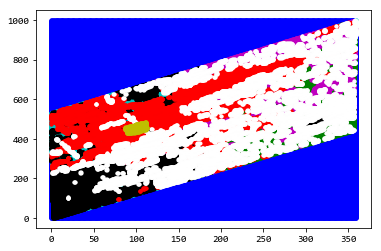

In [7]:
import itertools
points = {}
for x in itertools.product(range(result.shape[0]),range(result.shape[1])):
    print x
    points.setdefault(result[x[0],x[1]], []).append(x)
points
color= """bcgkmrwy"""
for k, v in points.items():
    c = color[k]
    plt.plot([x[0] for x in points[k]], [x[1] for x in points[k]], "%s." % c, label="%d" % k)
    